In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import Any, Optional, List

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IPositionGathering, IStrategy, PositionsTracker, StrategyContext, TriggerEvent
from qubx.pandaz.utils import *
import qubx.pandaz.ta as pta

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.ta.indicators import sma, ema
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC, AsOhlcvSeries
from qubx.core.basics import Deal, Instrument, Order, Position, Signal
from qubx.utils.charting.lookinglass import LookingGlass
from qubx.core.utils import recognize_time, time_to_str

from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet, chart_signals
from qubx.trackers.sizers import FixedSizer, FixedRiskSizer

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


# Test raw StopOrder

In [2]:
r = CsvStorageDataReader("../tests/data/csv")

In [36]:
instr = lookup.find_symbol("BINANCE.UM", "BTCUSDT")
ohlc = r.read("BTCUSDT_ohlcv_M1", start='2024-01-01', stop='2024-01-15', transform=AsOhlcvSeries())
stream = r.read("BTCUSDT_ohlcv_M1", start='2024-01-01', stop='2024-01-15', transform=RestoreTicksFromOHLC(trades=False, spread=instr.min_tick))

In [37]:
stream[0].mid_price()

42314.0

In [ ]:
LookingGlass([ohlc.pd()]).look(
    ).hline(stream[0].mid_price() + 1000
    ).hline(stream[0].mid_price() - 150
    ).hline(stream[0].mid_price() + 2000
    ).hline(stream[0].mid_price() - 1900
            ).hover()
# plt.axhline(stream[0].mid_price() + 150)

# Signals

In [52]:
I = lookup.find_symbol("BINANCE.UM", "BTCUSDT")
ohlc = CsvStorageDataReader("../tests/data/csv").read(
    "BTCUSDT_ohlcv_M1", start="2024-01-01", stop="2024-01-15", transform=AsPandasFrame()
)

if 1:
    LookingGlass([ohlc[1100:1800]]).look(
        ).vline("2024-01-01 20:00:00"
        ).hline(43800, c='red'
        ).hline(43654.50, c='green'
        ).hover(h=300).show()

In [3]:
class GuineaPig(IStrategy):
    tests = {}

    def on_fit(
        self, ctx: StrategyContext, fit_time: str , previous_fit_time: str | None = None
    ):
        self.tests = {recognize_time(k): v for k, v in self.tests.items()}

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        r = []
        for k in list(self.tests.keys()):
            if event.time >= k:
                r.append(self.tests.pop(k))
                # print(time_to_str(event.time))
        return r

In [53]:
from qubx.trackers.riskctrl import AtrRiskTracker, StopTakePositionTracker, AdvancedStopTakePositionTracker

result = simulate(
    {
        # "TEST": [
        #     GuineaPig(tests={"2024-01-01 20:00:00": I.signal(-1, stop=43800)}),
        #     StopTakePositionTracker(None, None, sizer=FixedRiskSizer(1)),
        # ],

        "TEST_Adv": [
            GuineaPig(tests={
                "2024-01-01 20:00:00": I.signal(-1, stop=43800, take=43400),
                "2024-01-01 23:10:00": I.signal(+1, stop=43400, take=44200),
                "2024-01-02 00:00:00": I.signal(+1, stop=43500, take=45500),
                "2024-01-02 01:10:00": I.signal(-1, stop=45500, take=44800),
                }),
            AdvancedStopTakePositionTracker(None, None, sizer=FixedRiskSizer(1)),
        ]
    }, {f"BINANCE.UM:BTCUSDT": ohlc}, 10000,
    instruments=[f"BINANCE.UM:BTCUSDT"], subscription=dict(type="ohlc", timeframe="1Min"), trigger="-1Sec", commissions="vip0_usdt",
    debug="DEBUG", start="2024-01-01", stop="2024-01-03",
)

2024-09-02 19:28:38.192 [ 🐞 ] 2024-01-01 00:00:00 Initiating simulated trading for binance.um for 10000 x 1.0 in USDT...
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedData.binance.um initialized


Simulating:   0%|          | 0/172800.0 [00:00<?, ?s/s]

2024-01-01 00:00:00.000 [ 🐞 ] Triggering strategy on every 1Min bar after 59S
2024-01-01 00:00:00.000 [ 🐞 ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1Min', 'nback': 1} for 
	['BTCUSDT'] 
2024-01-01 00:00:00.000 [ 🐞 ] SimulatedExchangeService :: subscribe :: BTCUSDT :: ohlc
2024-01-01 00:00:00.000 [ 🐞 ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1Min', 'nback': 1} for 
	['BTCUSDT'] 
2024-01-01 00:00:00.000 [ 🐞 ] SimulatedExchangeService :: subscribe :: BTCUSDT :: ohlc
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedExchangeService :: run :: Simulation started at 2024-01-01
2024-01-01 00:00:00.000 [ 🐞 ] Initializing chunks for each loader
2024-01-01 00:00:00.001 [ 🐞 ] [2024-01-01T00:00:00.001000000]: Invoking GuineaPig on_fit('2024-01-01 00:00:00', 'None')
2024-01-01 00:00:00.001 [ 🐞 ] [2024-01-01T00:00:00.001000000]: GuineaPig is fitted
2024-01-01 20:00:59.999 [ 🐞 ] AdvancedStopTakePositionTracker started tracking Target for GuineaPig 43654.50 -

In [49]:
result[0].executions_log

,instrument_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,
2024-01-01 20:00:59.999,BTCUSDT,sell,-0.687,43654.45,14.995304,USDT
2024-01-01 20:13:36.000,BTCUSDT,buy,0.687,43800.00,15.045300,USDT
2024-01-01 23:10:59.999,BTCUSDT,buy,0.321,43707.05,7.014982,USDT
2024-01-01 23:51:36.000,BTCUSDT,sell,-0.321,44200.00,2.837640,USDT
2024-01-02 00:00:59.999,BTCUSDT,buy,0.136,44233.55,3.007881,USDT
2024-01-02 03:00:24.000,BTCUSDT,sell,-0.136,45500.00,1.237600,USDT


In [54]:
result[0].signals_log

,instrument_id,exchange_id,signal,target_position,reference_price,price,take,stop,group,comment,service
timestamp,,,,,,,,,,,
2024-01-01 20:00:59.999,BTCUSDT,BINANCE.UM,-1,-0.687,43654.5,NaN,43400.0,43800.0,GuineaPig,,False
2024-01-01 20:13:36.000,BTCUSDT,BINANCE.UM,0,0.000,43815.0,43800.0,NaN,NaN,Risk Manager,Stop triggered,True
2024-01-01 23:10:59.999,BTCUSDT,BINANCE.UM,1,0.321,43707.0,NaN,44200.0,43400.0,GuineaPig,,False
2024-01-01 23:51:36.000,BTCUSDT,BINANCE.UM,0,0.000,44222.6,44200.0,NaN,NaN,Risk Manager,Take triggered,True
2024-01-02 00:00:59.999,BTCUSDT,BINANCE.UM,1,0.136,44233.5,NaN,45500.0,43500.0,GuineaPig,,False
2024-01-02 01:10:59.999,BTCUSDT,BINANCE.UM,-1,-0.405,45249.4,NaN,44800.0,45500.0,GuineaPig,,False
2024-01-02 01:49:36.000,BTCUSDT,BINANCE.UM,0,0.000,44750.0,44800.0,NaN,NaN,Risk Manager,Take triggered,True


In [55]:
chart_signals(result[0], 'BTCUSDT', {f"BTCUSDT": ohlc}, show_signals=True)

In [41]:
ohlc

,close,high,low,open,volume
timestamp,,,,,
2024-01-01 00:00:00,42331.9,42335.8,42289.6,42314.0,289.641
2024-01-01 00:01:00,42350.4,42353.1,42331.8,42331.9,202.444
2024-01-01 00:02:00,42360.2,42370.8,42349.6,42350.4,271.521
2024-01-01 00:03:00,42405.8,42405.8,42360.1,42360.1,392.238
2024-01-01 00:04:00,42437.1,42437.2,42405.7,42405.7,568.366
...,...,...,...,...,...
2024-01-14 23:56:00,41840.4,41854.5,41785.4,41789.0,256.471
2024-01-14 23:57:00,41848.7,41855.4,41821.0,41840.3,202.699
2024-01-14 23:58:00,41814.3,41853.0,41814.3,41848.7,150.559


# ATR position tracker tests

In [2]:
from qubx.trackers.riskctrl import AtrRiskTracker, StopTakePositionTracker, AdvancedStopTakePositionTracker

In [3]:
r = CsvStorageDataReader("../tests/data/csv")

In [12]:
class StrategyForTracking(IStrategy):
    timeframe: str = "1Min"
    fast_period = 5
    slow_period = 12

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        signals = []
        for i in ctx.instruments:
            ohlc = ctx.ohlc(i, self.timeframe)
            fast = sma(ohlc.close, self.fast_period)
            slow = sma(ohlc.close, self.slow_period)
            pos = ctx.positions[i.symbol].quantity

            if pos <= 0 and (fast[0] > slow[0]) and (fast[1] < slow[1]):
                signals.append(i.signal(+1, stop=ohlc[0].low))

            if pos >= 0 and (fast[0] < slow[0]) and (fast[1] > slow[1]):
                signals.append(i.signal(-1, stop=ohlc[0].high))

        return signals

    def tracker(self, ctx: StrategyContext) -> PositionsTracker:
       return PositionsTracker(FixedRiskSizer(1, 10_000, reinvest_profit=True))

In [13]:
rep = simulate(
    {
        "As Strategy 1": [
            StrategyForTracking(timeframe="15Min", fast_period=5, slow_period=25),
        ],
        "As Strategy 2": [
            StrategyForTracking(timeframe="15Min", fast_period=5, slow_period=25),
            # - it will replace strategy defined tracker
            AtrRiskTracker(2, 1, "15Min", 50, atr_smoother="kama", sizer=FixedRiskSizer(0.5)),
        ],
    },
    r, 10000, ["BINANCE.UM:BTCUSDT"], 
    dict(type="ohlc", timeframe="15Min"), "-1Sec", "vip0_usdt", "2024-01-01", "2024-01-05",
    debug='debug'
)

# assert len(rep[0].executions_log) == 23
# assert len(rep[1].executions_log) == 24

  0%|          | 0/2 [00:00<?, ?it/s]

2024-09-03 18:44:33.035 [ 🐞 ] 2024-01-01 00:00:00 Initiating simulated trading for binance.um for 10000 x 1.0 in USDT...
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedData.binance.um initialized
2024-01-01 00:00:00.000 [ 🐞 ] Triggering strategy on every 15Min bar after 14Min59S


Simulating:   0%|          | 0/345600.0 [00:00<?, ?s/s]

2024-01-01 00:00:00.000 [ 🐞 ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '15Min', 'nback': 1} for 
	['BTCUSDT'] 
2024-01-01 00:00:00.000 [ 🐞 ] SimulatedExchangeService :: subscribe :: BTCUSDT :: ohlc
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedExchangeService :: run :: Simulation started at 2024-01-01
2024-01-01 00:00:00.000 [ 🐞 ] Initializing chunks for each loader
2024-01-01 00:00:00.001 [ 🐞 ] [2024-01-01T00:00:00.001000000]: Invoking StrategyForTracking on_fit('2024-01-01 00:00:00', 'None')
2024-01-01 00:00:00.001 [ 🐞 ] [2024-01-01T00:00:00.001000000]: StrategyForTracking is fitted
2024-01-01 07:44:59.999 [ 🐞 ] (StrategyContext) sending market buy for 0.235 of BTCUSDT @ None ...
2024-01-01 07:44:59.999 [ 🐞 ] [OMS] BTCUSDT - SIM-ORDER-BTCUSDT-100001 MARKET BUY 0.235 executed at 42475.450000000004
2024-01-01 07:44:59.999 [ 🐞 ]   ::  traded 0.235 for BTCUSDT @ 42475.450000000004 -> 0.00
2024-01-01 07:44:59.999 [ 🐞 ] Order SIM-ORDER-BTCUSDT-100001 MARKET BUY 0.235 of 

Simulating:   0%|          | 0/345600.0 [00:00<?, ?s/s]

2024-01-01 00:00:00.000 [ 🐞 ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '15Min', 'nback': 1} for 
	['BTCUSDT'] 
2024-01-01 00:00:00.000 [ 🐞 ] SimulatedExchangeService :: subscribe :: BTCUSDT :: ohlc
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedExchangeService :: run :: Simulation started at 2024-01-01
2024-01-01 00:00:00.000 [ 🐞 ] Initializing chunks for each loader
2024-01-01 00:00:00.001 [ 🐞 ] [2024-01-01T00:00:00.001000000]: Invoking StrategyForTracking on_fit('2024-01-01 00:00:00', 'None')
2024-01-01 00:00:00.001 [ 🐞 ] [2024-01-01T00:00:00.001000000]: StrategyForTracking is fitted
2024-01-01 14:59:59.999 [ 🐞 ] AtrRiskTracker started tracking Target for StrategyForTracking 42645.60 -1.000000 BTCUSDT stop: 42762.81949727086 take: 42411.01100545827 on BINANCE.UM [] -> -0.426 at 2024-01-01T14:59:59.999000000 of BTCUSDT take: 42411.01100545827 stop: 42762.81949727086
2024-01-01 14:59:59.999 [ 🐞 ] (StrategyContext) sending market sell for 0.426 of BTCUSDT @ None ...
20

2024-01-04 15:28:36.000 [ 🐞 ] [SIM-ORDER-BTCUSDT-100035 / StrategyForTracking_BTCUSDT_17040672035] : LIMIT SELL 0.105 of BTCUSDT  @ 44068.2 -> [CLOSED]
2024-01-04 15:28:36.000 [ 🐞 ] Executed -0.105 @ 44157.149999999994 of BTCUSDT for order SIM-ORDER-BTCUSDT-100035
2024-01-04 15:28:36.000 [ 🐞 ] BTCUSDT >>> Adjusting position from 0.105 to 0.0 : [SIM-ORDER-BTCUSDT-100035] LIMIT SELL 0.105 of BTCUSDT @ 44068.2 (gtc) [CLOSED]
2024-01-04 15:28:59.999 [ 🐞 ] AtrRiskTracker stops tracking BTCUSDT
2024-01-05 00:00:59.999 [ ℹ️ ] SimulatedExchangeService :: run :: Simulation finished at 2024-01-05 00:00:00


,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,/As Strategy 1,97.803276,1.034999,1.823499,-0.001653,10.014674,1098.253455,3.293260,30.793275,0.886116,0.469516,310.438747,0.215374,224.611924,23.0
1,/As Strategy 2,-376.364488,-0.939220,-13.194334,-4.941392,4.798180,479.817988,-14.079051,-34.633992,0.061792,0.736308,237.719193,-0.759425,166.471638,35.0


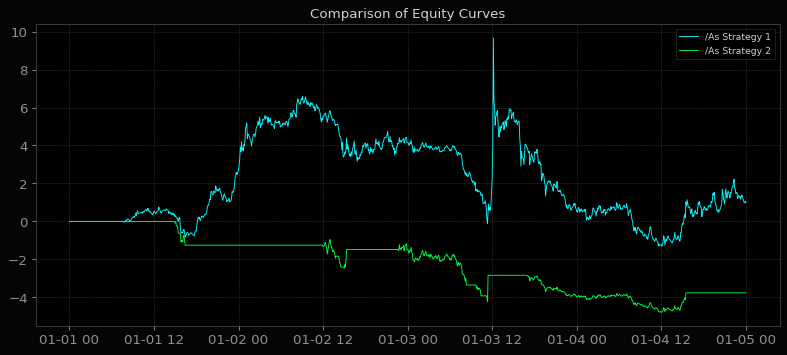

In [15]:
tearsheet(rep)

In [11]:
chart_signals(rep[1], 'BTCUSDT', 
              r.read("BINANCE.UM:BTCUSDT", "2024-01-01", "2024-01-05", transform=AsPandasFrame()), 
              timeframe='15Min',
              show_trades=True, show_signals=True)

In [ ]:
rep[1].executions_log